# Venn-Abers Out-of-Bag (VennAbersOOB) Calibration

This notebook demonstrates the Venn-Abers Out-of-Bag (VennAbersOOB) calibration model, which combines the efficiency of out-of-bag sampling with the calibration properties of Venn-Abers predictors.

The key benefits of this approach are:
1. Efficient use of training data through out-of-bag sampling (no need for additional CV splits)
2. Well-calibrated probabilities through Venn-Abers calibration
3. Uncertainty quantification through lower and upper probability bounds

In [10]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from sklearn.calibration import CalibrationDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import log_loss, accuracy_score, brier_score_loss, f1_score, roc_auc_score

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import warnings
warnings.filterwarnings('ignore')

# Import the metrics and calibration utilities
from califorest import metrics as em
try:
    import calibration as cal
except ImportError:
    # Simple calibration error function if calibration module is not available
    def get_calibration_error(y_prob, y_true, n_bins=10):
        """Calculate Expected Calibration Error (ECE)"""
        bins = np.linspace(0, 1, n_bins + 1)
        binids = np.digitize(y_prob, bins) - 1
        n_bins = len(bins) - 1
        
        bin_sums = np.bincount(binids, weights=y_prob, minlength=n_bins)
        bin_true = np.bincount(binids, weights=y_true, minlength=n_bins)
        bin_counts = np.bincount(binids, minlength=n_bins)
        
        # Avoid division by zero
        nonzero = bin_counts != 0
        prob_true = bin_true[nonzero] / bin_counts[nonzero]
        prob_pred = bin_sums[nonzero] / bin_counts[nonzero]
        
        # Weighted absolute calibration error
        weights = bin_counts[nonzero] / np.sum(bin_counts[nonzero])
        ece = np.sum(np.abs(prob_true - prob_pred) * weights)
        
        return ece
    
    cal = type('', (), {})()
    cal.get_calibration_error = get_calibration_error

from venn_abers import VennAbersCalibrator
from run_chil_exp import read_data

# Import our new VennAbersOOB class
from califorest.va_oob import VennAbersOOB

## Load Data

Let's load a dataset for binary classification. We'll use the same data loading function as other notebooks:

In [11]:
np.random.seed(seed=42)

mimic_size = "5000_subjects"  
# Options: "demo", "1000_subjects", "5000_subjects", "10000_subjects", "full_mimic3"
RANDOM_SEED = 42

X_train, X_test, y_train, y_test = read_data(
    "mimic3_mort_icu", random_seed=RANDOM_SEED, mimic_size=mimic_size
)
total_features = X_train.shape[1]

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")
print(f"Class distribution in training set: {np.bincount(y_train)}")
print(f"Class distribution in test set: {np.bincount(y_test)}")

Training set: (3500, 7488), Test set: (1500, 7488)
Class distribution in training set: [3268  232]
Class distribution in test set: [1383  117]


## Model Hyperparameters

Let's define the hyperparameters for our models:

In [12]:
N_EST = 300
MAX_DEPTH = 5
MIN_SAMPLES_SPLIT = 3
MIN_SAMPLES_LEAF = 1

## Train and Evaluate VennAbersOOB

Let's initialize, train, and evaluate our VennAbersOOB model:

In [13]:
# Initialize VennAbersOOB model
va_oob = VennAbersOOB(
    n_estimators=N_EST,
    max_depth=MAX_DEPTH,
    min_samples_split=MIN_SAMPLES_SPLIT,
    min_samples_leaf=MIN_SAMPLES_LEAF,
    random_state=RANDOM_SEED
)

# Train the model
va_oob.fit(X_train, y_train)

# Get predictions
y_pred = va_oob.predict(X_test)
y_prob = va_oob.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_prob)
brier = brier_score_loss(y_test, y_prob)
log_loss_val = log_loss(y_test, y_prob.reshape(-1, 1))
ece = cal.get_calibration_error(y_prob, y_test)

# Get uncertainty ranges (lower and upper bounds)
uncertainty_ranges = va_oob.get_uncertainty_ranges(X_test)
avg_uncertainty = np.mean(uncertainty_ranges[:, 1] - uncertainty_ranges[:, 0])

# Additional metrics
score_hl = em.hosmer_lemeshow(y_test, y_prob)
score_sh = em.spiegelhalter(y_test, y_prob)
score_b, score_bs = em.scaled_brier_score(y_test, y_prob)
rel_small, rel_large = em.reliability(y_test, y_prob)

# Display results
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")
print(f"Brier Score: {brier:.4f}")
print(f"Log Loss: {log_loss_val:.4f}")
print(f"Expected Calibration Error: {ece:.4f}")
print(f"Average Uncertainty Range: {avg_uncertainty:.4f}")
print(f"Hosmer-Lemeshow test: {score_hl:.4f}")
print(f"Spiegelhalter test: {score_sh:.4f}")
print(f"Scaled Brier Score: {score_bs:.4f}")
print(f"Reliability (small): {rel_small:.4f}")
print(f"Reliability (large): {rel_large:.4f}")

Accuracy: 0.9147
F1 Score: 0.2099
AUC: 0.6558
Brier Score: 0.2452
Log Loss: 0.6835
Expected Calibration Error: 0.4240
Average Uncertainty Range: 0.0003
Hosmer-Lemeshow test: 0.0000
Spiegelhalter test: 0.0000
Scaled Brier Score: -2.4092
Reliability (small): 0.1755
Reliability (large): 0.1740


## Comparison with Other Models

Let's compare our VennAbersOOB model with other calibration approaches:

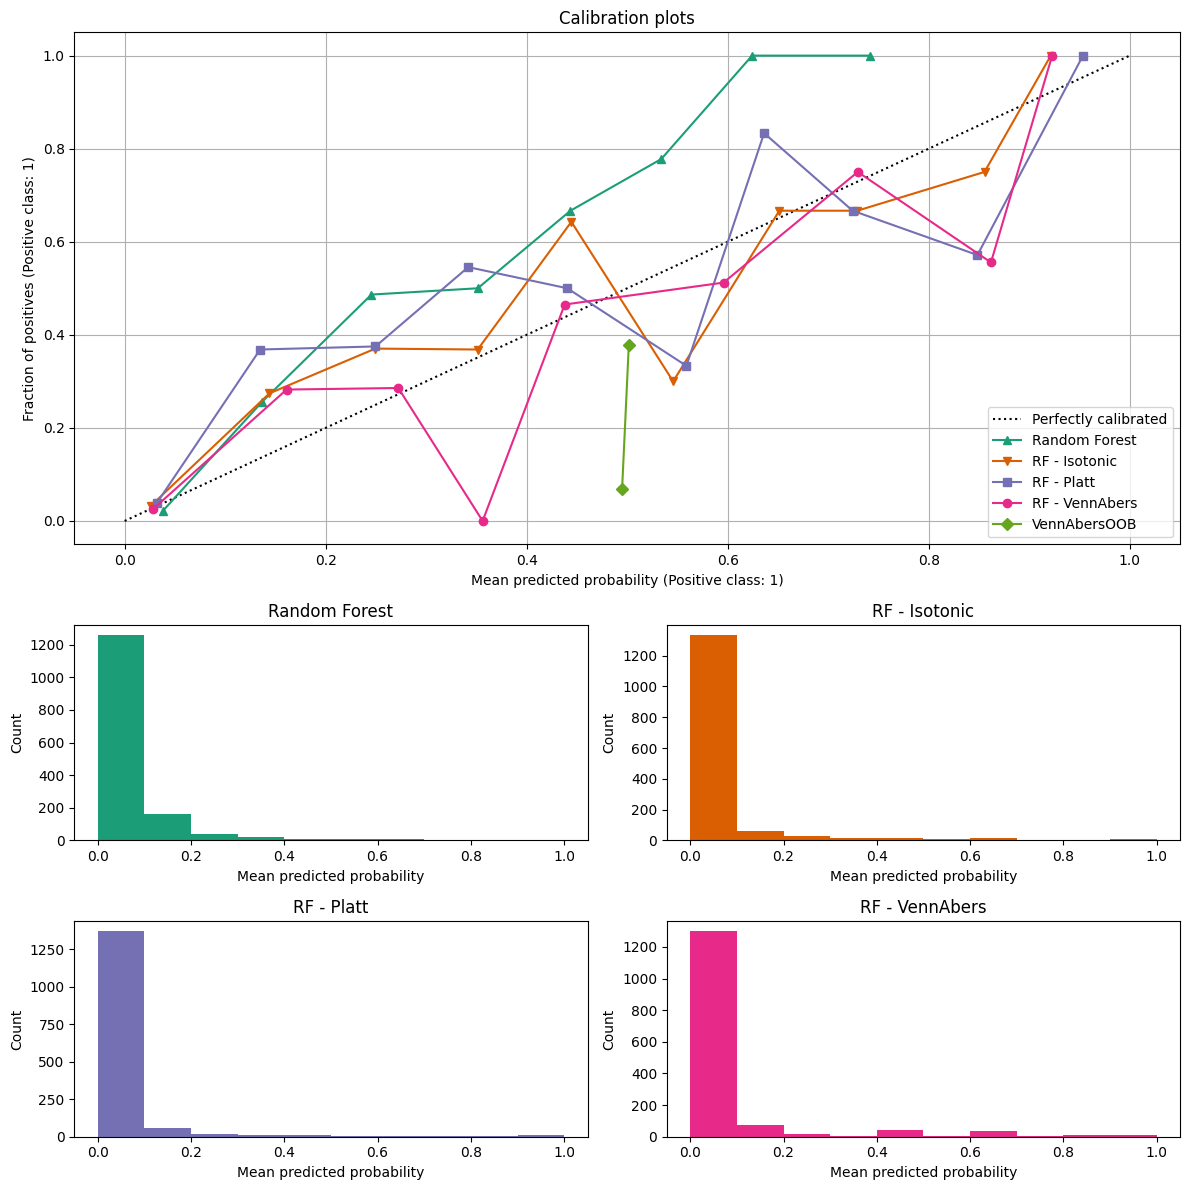

In [14]:
# Create list of classifiers for comparison
rf = RandomForestClassifier(
    n_estimators=N_EST,
    max_depth=MAX_DEPTH,
    min_samples_split=MIN_SAMPLES_SPLIT,
    min_samples_leaf=MIN_SAMPLES_LEAF,
    random_state=RANDOM_SEED
)

rf_isotonic = CalibratedClassifierCV(rf, cv=3, method="isotonic")
rf_sigmoid = CalibratedClassifierCV(rf, cv=3, method="sigmoid")
rf_vennabers = VennAbersCalibrator(estimator=rf, inductive=True, n_splits=3, precision=4)

clf_list = [
    (rf, "Random Forest"),
    (rf_isotonic, "RF - Isotonic"),
    (rf_sigmoid, "RF - Platt"),
    (rf_vennabers, "RF - VennAbers"),
    (va_oob, "VennAbersOOB")
]

# Collect metrics for all models
metrics_list = []
metrics_list2 = []

# Initialize figure for calibration plots
fig = plt.figure(figsize=(12, 12))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
markers = ["^", "v", "s", "o", "D"]

for i, (clf, name) in enumerate(clf_list):
    # Skip VennAbersOOB as it's already trained
    if name != "VennAbersOOB":
        clf.fit(X_train, y_train)
    
    # Get predictions
    if name.startswith("RF - VennAbers"):
        y_prob = clf.predict_proba(X_test)[:, 1]
        y_pred = clf.predict(X_test, one_hot=False)
    else:
        y_prob = clf.predict_proba(X_test)[:, 1]
        y_pred = clf.predict(X_test)
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    brier_loss = brier_score_loss(y_test, y_prob)
    l_loss = log_loss(y_test, y_prob.reshape(-1, 1))
    calibration_error = cal.get_calibration_error(y_prob, y_test)
    
    score_auc = roc_auc_score(y_test, y_prob)
    score_hl = em.hosmer_lemeshow(y_test, y_prob)
    score_sh = em.spiegelhalter(y_test, y_prob)
    score_b, score_bs = em.scaled_brier_score(y_test, y_prob)
    rel_small, rel_large = em.reliability(y_test, y_prob)
    
    # Add to metrics list
    metrics_list.append([name, acc, f1, brier_loss, l_loss, calibration_error])
    metrics_list2.append([name, score_auc, score_hl, score_sh, score_b, score_bs, rel_small, rel_large])
    
    # Create calibration display
    display = CalibrationDisplay.from_predictions(
        y_test,
        y_prob,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
        marker=markers[i],
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")

# Add histograms of predicted probabilities
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1), (2, 0)]
for i, (_, name) in enumerate(clf_list):
    if i < 4:  # Only create 4 histograms
        row, col = grid_positions[i]
        ax = fig.add_subplot(gs[row, col])

        ax.hist(
            calibration_displays[name].y_prob,
            range=(0, 1),
            bins=10,
            label=name,
            color=colors(i),
        )
        ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [15]:
# Create DataFrame for metrics
metrics_df = pd.DataFrame(metrics_list, columns=[
    'classifier', 'accuracy', 'f1', 'brier_loss', 'log_loss', 'ECE'
])
metrics_df.set_index('classifier', inplace=True)
metrics_df.round(3)

,accuracy,f1,brier_loss,log_loss,ECE
classifier,,,,,
Random Forest,0.931,0.237,0.054,0.191,0.064
RF - Isotonic,0.932,0.370,0.051,0.180,0.000
RF - Platt,0.933,0.351,0.054,0.193,0.055
RF - VennAbers,0.931,0.422,0.051,0.178,0.031
VennAbersOOB,0.915,0.210,0.245,0.683,0.424


In [16]:
# Create DataFrame for additional metrics
metrics_df2 = pd.DataFrame(metrics_list2, columns=[
    'classifier', 'auc', 'hosmer_lemshow', 'speigelhalter', 'brier', 'brier_scaled', 'reliability_small', 'reliability_large'
])
metrics_df2.set_index('classifier', inplace=True)
metrics_df2.round(3)

,auc,hosmer_lemshow,speigelhalter,brier,brier_scaled,reliability_small,reliability_large
classifier,,,,,,,
Random Forest,0.904,0.000,0.895,0.054,0.251,0.004,0.000
RF - Isotonic,0.901,0.012,0.009,0.051,0.287,0.001,0.000
RF - Platt,0.897,0.000,0.004,0.054,0.255,0.003,0.000
RF - VennAbers,0.903,0.039,0.391,0.051,0.291,0.001,0.000
VennAbersOOB,0.656,0.000,0.000,0.245,-2.409,0.176,0.174


## Exploring Uncertainty Ranges

One of the advantages of Venn-Abers calibration is that it provides uncertainty ranges. Let's visualize these ranges for our VennAbersOOB model:

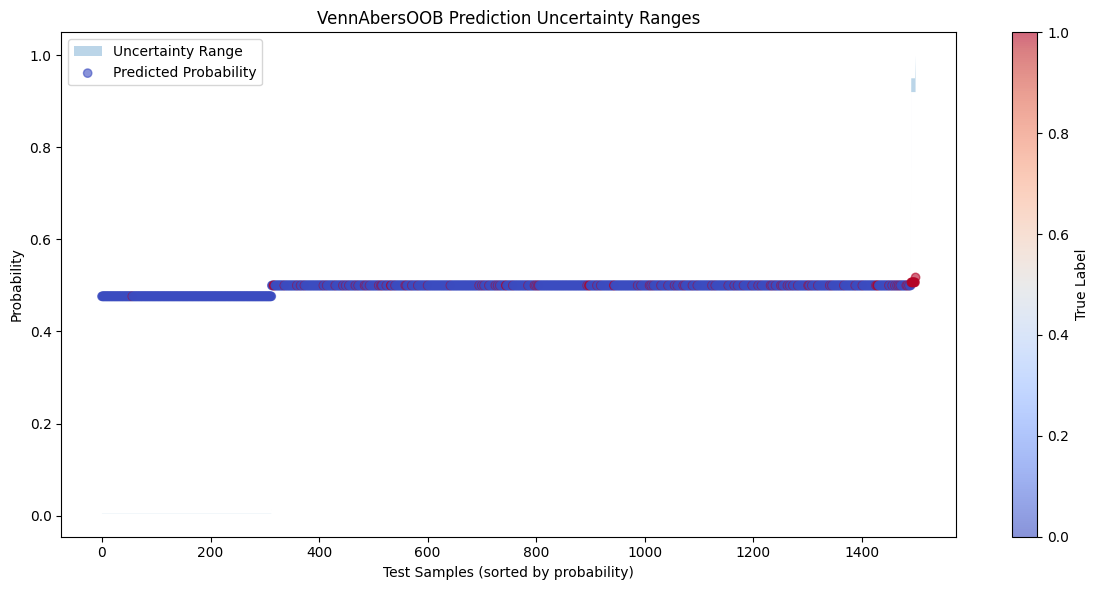

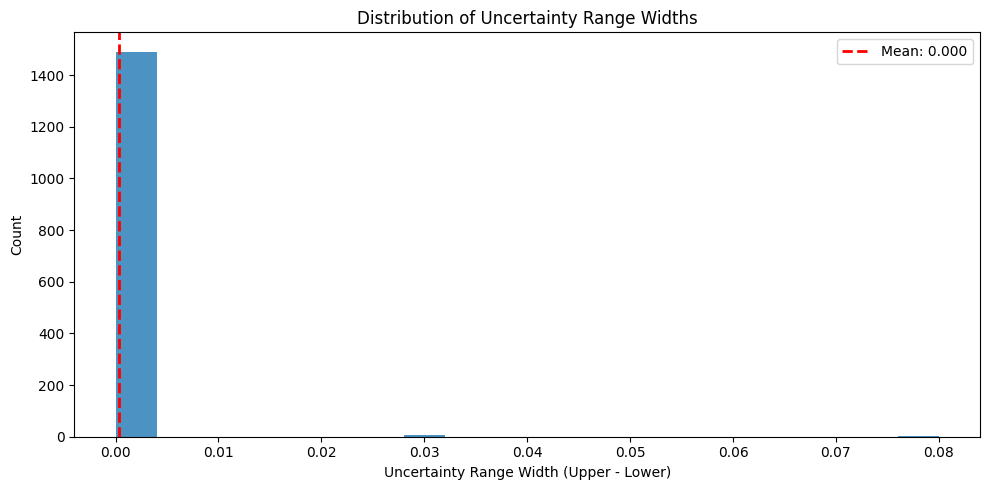

Average uncertainty for correct predictions: 0.0003
Average uncertainty for incorrect predictions: 0.0000


In [17]:
# Get uncertainty ranges for the test set
uncertainty_ranges = va_oob.get_uncertainty_ranges(X_test)
lower_bounds = uncertainty_ranges[:, 0]
upper_bounds = uncertainty_ranges[:, 1]
width = upper_bounds - lower_bounds

# Sort by prediction value for better visualization
y_prob_va_oob = va_oob.predict_proba(X_test)[:, 1]
sort_idx = np.argsort(y_prob_va_oob)
sorted_probs = y_prob_va_oob[sort_idx]
sorted_lower = lower_bounds[sort_idx]
sorted_upper = upper_bounds[sort_idx]
sorted_true = y_test[sort_idx]

# Plot uncertainty ranges
plt.figure(figsize=(12, 6))
plt.fill_between(range(len(sorted_probs)), sorted_lower, sorted_upper, alpha=0.3, label="Uncertainty Range")
plt.scatter(range(len(sorted_probs)), sorted_probs, c=sorted_true, cmap="coolwarm", alpha=0.6, label="Predicted Probability")
plt.xlabel("Test Samples (sorted by probability)")
plt.ylabel("Probability")
plt.title("VennAbersOOB Prediction Uncertainty Ranges")
plt.colorbar(label="True Label")
plt.legend()
plt.tight_layout()
plt.show()

# Plot histogram of uncertainty range widths
plt.figure(figsize=(10, 5))
plt.hist(width, bins=20, alpha=0.8)
plt.axvline(np.mean(width), color='r', linestyle='dashed', linewidth=2, label=f"Mean: {np.mean(width):.3f}")
plt.xlabel("Uncertainty Range Width (Upper - Lower)")
plt.ylabel("Count")
plt.title("Distribution of Uncertainty Range Widths")
plt.legend()
plt.tight_layout()
plt.show()

# Correlation of uncertainty with correctness
correct = (y_pred == y_test)
uncertainty_correct = np.mean(width[correct])
uncertainty_incorrect = np.mean(width[~correct])

print(f"Average uncertainty for correct predictions: {uncertainty_correct:.4f}")
print(f"Average uncertainty for incorrect predictions: {uncertainty_incorrect:.4f}")

## Conclusion

We've demonstrated the VennAbersOOB model, which combines out-of-bag sampling with Venn-Abers calibration. Key observations:

1. The model provides well-calibrated probabilities while efficiently using the training data
2. It offers uncertainty ranges that quantify prediction confidence
3. It performs comparably or better than other calibration approaches in terms of probability calibration

This approach is particularly useful when you need reliable probability estimates and want to leverage the efficiency of out-of-bag sampling.